# Loading cNMF output and CS design matrices into anndata
## FOR Q1Q2 (plate 1+2) post QC & hash demultiplex, cNMF prep
#### _BEM 08-15-2022_


### What this does:
- Input data:
    - Adata files with Q1Q2 (plate 1+2) post QC & hash demultiplex scRNA-seq dataset
    - cNMF gene spectra scores, module usage, and highly variable genes from running cNMF wdl file
    - Design matrices indicating which drugs went into which wells in the compressed screens
- Loads in all inputs into anndata file
- Identifies cNMF modules that are highly variable across cells

In [1]:
import os
import sys
import warnings
import random
import itertools
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
from kneed import KneeLocator

from scipy.io import mmread
import scipy.sparse as sp
import matplotlib.pyplot as plt
from IPython.display import Image
from cnmf import cNMF

sc.settings.verbosity = 3           # verbosity: errors (0), warnings (1), info (2), hints (3)

## Prep anndata

#### metadata helper

In [19]:
def add_design_matrix(adata, plate_design_path):
    # Load design matrix
    plate1_design = pd.read_csv(plate_design_path,index_col=0)
    plate1_design = plate1_design.rename(columns={'TNF':'TNFa', 'TGFB1':'TGFbeta1'})

    # Add Metadata_perturbation to anndata: based on design matrix
    Metadata_perturbation = ['random']*len(plate1_design.index)
    Controls = (np.sum(plate1_design, axis = 1) == 0)
    Landmarks = (np.sum(plate1_design, axis = 1) == 1)

    # Build list of perturbations
    for i in list(range(len(Metadata_perturbation))):
        if Controls[i]:
            Metadata_perturbation[i] = 'Control'
        elif Landmarks[i]:
            Metadata_perturbation[i] = plate1_design.columns[plate1_design.iloc[i,:] == 1][0]

    # Add well as index
    Metadata_perturbation = pd.DataFrame(Metadata_perturbation, 
                                         columns = ['Metadata_perturbation'], 
                                         index = plate1_design.index).reset_index()

    # Map back to anndata
    Metadata_perturbation = pd.DataFrame(adata.obs['sample_well']).rename(columns={'sample_well':'index'}).\
                            merge(Metadata_perturbation,how='left',on='index').\
                            drop(['index'],axis=1)

    adata.obs['Metadata_perturbation'] = Metadata_perturbation.Metadata_perturbation.values

    # add metadata for landmarks
    LM_list = list(set(adata.obs.Metadata_perturbation.values)-set(['random']))

    LM_df = pd.DataFrame(columns = LM_list)

    for LM in LM_list:
        LM_df[LM] = (adata.obs.Metadata_perturbation == LM)
        LM_df[LM] = adata.obs.Metadata_perturbation[(adata.obs.Metadata_perturbation == LM)]

        adata.obs[LM] = LM_df[LM]

    adata.obs['landmarks'] = LM_df.astype(str).replace('nan', '').sum(axis=1)
    adata.obs.loc[adata.obs.landmarks == '', 'landmarks'] = np.nan

    # Add Design matrix to anndata
    plate1_design = plate1_design.reset_index()
    adata.obs['index'] = adata.obs['sample_well']

    design_mat = pd.DataFrame(adata.obs['index']).\
                 merge(plate1_design,how='left',on='index').\
                 drop(['index'],axis=1)

    adata.obsm['design_matrix']=np.array(design_mat)
    adata.uns['design_matrix_perturbations'] = design_mat.columns.values.tolist()
    adata.obs = adata.obs.drop(columns=['index'])
    
    return(adata)



#### cell # plotting

In [20]:
def cell_num_plot(adata, fig_name):
    
    # Make table of cells by perturbations
    cell_num_pert = pd.DataFrame(adata.obsm['design_matrix_with_media'], 
                                 columns = adata.uns['design_matrix_perturbations_with_media'], 
                                 index = adata.obs.index)

    cell_num_pert.loc[:,'media'] = (cell_num_pert.iloc[:,:-1].sum(axis=1)==0)*1

    # Review cell # per perturbation
    p_cell_num_pert = plot_cell_num_pert(cell_num_pert, fig_name)

    summary_cell_num = pd.DataFrame(cell_num_pert.sum(axis=0),columns = ['cell_#']).sort_values(by='cell_#')
    
    print('3 highest perturbations:')
    print(summary_cell_num.iloc[-4:-1,:])
    print('3 lowest perturbations:')
    print(summary_cell_num.iloc[:3,:])
    
    return(summary_cell_num)


In [21]:
def cell_num_downsample_plot(plot_cell_num_pert, fig_name):
    
    g = sns.histplot(plot_cell_num_pert, x='cell_#', legend = True,
                 element="step", multiple='layer', stat='density', bins = 20,
                 hue="type", palette=['grey', 'red'])

    g.figure.savefig('figures/'+fig_name+'.pdf');

        
def plot_cell_num_pert(cell_num_pert, fig_name):
    
    plot_cell_num_pert = pd.DataFrame(cell_num_pert.sum(axis=0),
                                  columns = ['cell_#'])
    plot_cell_num_pert['type'] = 'perturbation'
    plot_cell_num_pert.iloc[-1,1] = 'media'
    
    cell_num_downsample_plot(plot_cell_num_pert, fig_name)
    
    return(plot_cell_num_pert)

### Paths to files

In [22]:
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.4.6 numpy==1.23.2 scipy==1.9.0 pandas==1.4.1 scikit-learn==1.1.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.2


In [23]:
h5ad_path = '../../../PDAC_CS_data_lock/PDAC_sept1_data_lock/1_Preprocess/'

plate1_input = h5ad_path + "PDAC_CS_SSwl_q1_demulti_g500_BEM_20220901.h5ad"
plate2_input = h5ad_path + "PDAC_CS_SSwl_q2_demulti_g500_BEM_20220901.h5ad"

### Plate 1

In [43]:
# Load plate 1 (Q1) star solo - QC/preprocess/demulti in seurat
adata = sc.read(plate1_input)
del adata.raw
adata.var.index = adata.var._index
adata.var.index.rename(name='index', inplace=True)
del adata.var['_index']

# Clean up metadata\
metadata_to_drop = ['orig.ident', 'array', 'nCount_HTO', 'nFeature_HTO', 'plate_row', 
                    'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification',
                    'HTO_classification.global', 'hash.ID', 'plate_column']

adata.obs = adata.obs.drop(metadata_to_drop, axis=1)

print("data shape:", adata.shape)

# Add design matrix
adata = add_design_matrix(adata, plate_design_path = '../1_Data/design_matrices/plate1.csv')

adata.obsm['design_matrix_with_media'] = np.hstack([adata.obsm['design_matrix'],
                                                    np.repeat(1,adata.obsm['design_matrix'].shape[0]).reshape(adata.obsm['design_matrix'].shape[0],1)])
adata.uns['design_matrix_perturbations_with_media'] = np.hstack([adata.uns['design_matrix_perturbations'],
                                                                 ["media"]])

plate1 = adata

data shape: (5662, 15970)


3 highest perturbations:
      cell_#
AREG   434.0
IL1A   459.0
FGF2   478.0
3 lowest perturbations:
       cell_#
RANKL    99.0
IFNA2   119.0
LPA     124.0


/Users/bemead/anaconda3/envs/comp_screening/lib/python3.8/site-packages/anndata/_core/anndata.py:859: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_df(value, "obs")


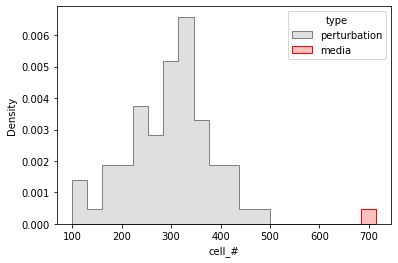

In [44]:
# plot cell # perturbations in pools dataset 
adata_pools = adata[adata.obs.Metadata_perturbation.isin(['Control','random'])]
# Clean up metadata
adata_pools.obs = adata_pools.obs.drop(['TNFa','TGFbeta1','IFNG'], axis=1)

p1_summary = cell_num_plot(adata_pools, fig_name="plate1_pools")

### Plate 2

In [40]:
# Load plate 2 (Q2) star solo - QC/preprocess/demulti in seurat
adata = sc.read(plate2_input)
del adata.raw
adata.var.index = adata.var._index
adata.var.index.rename(name='index', inplace=True)
del adata.var['_index']

# Clean up metadata\
metadata_to_drop = ['orig.ident', 'array', 'nCount_HTO', 'nFeature_HTO', 'plate_row', 
                    'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification',
                    'HTO_classification.global', 'hash.ID', 'plate_column']

adata.obs = adata.obs.drop(metadata_to_drop, axis=1)

print("data shape:", adata.shape)

# Add design matrix
adata = add_design_matrix(adata, plate_design_path = '../1_Data/design_matrices/plate2.csv')

adata.obsm['design_matrix_with_media'] = np.hstack([adata.obsm['design_matrix'],
                                                    np.repeat(1,adata.obsm['design_matrix'].shape[0]).reshape(adata.obsm['design_matrix'].shape[0],1)])
adata.uns['design_matrix_perturbations_with_media'] = np.hstack([adata.uns['design_matrix_perturbations'],
                                                                 ["media"]])

plate2 = adata

data shape: (10881, 16633)


/Users/bemead/anaconda3/envs/comp_screening/lib/python3.8/site-packages/anndata/_core/anndata.py:859: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_df(value, "obs")


3 highest perturbations:
         cell_#
EPO       878.0
RARRES2   892.0
IL15      959.0
3 lowest perturbations:
       cell_#
RANKL   150.0
IL17A   214.0
LPA     243.0


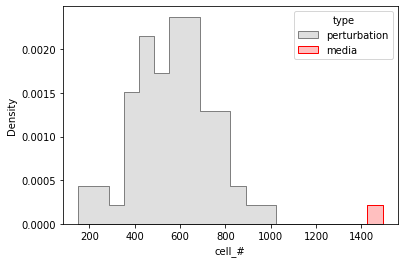

In [42]:
# plot cell # perturbations in pools dataset 
adata_pools = adata[adata.obs.Metadata_perturbation.isin(['Control','random'])]
# Clean up metadata
adata_pools.obs = adata_pools.obs.drop(['TNFa','TGFbeta1','IFNG'], axis=1)

p2_summary = cell_num_plot(adata_pools, fig_name="plate2_pools")

### Merge plates

In [27]:
# make a combined plate

# merge anndatas for plates 1+2
var_names = plate1.var_names.intersection(plate2.var_names)
plate1 = plate1[:, var_names]
plate2 = plate2[:, var_names]

adata_concat = plate1.concatenate(plate2, batch_categories=['plate1', 'plate2'])

adata_concat.uns['design_matrix_perturbations'] = plate1.uns['design_matrix_perturbations']

# Select variable genes - combined
sc.experimental.pp.highly_variable_genes(adata_concat, flavor="pearson_residuals", n_top_genes=3000)

# save variable genes to file
plate12concat_hvg = adata_concat.var['highly_variable'][adata_concat.var['highly_variable']].index.values

file=open('h5ad_files/plate1_2_concat_hvg.txt','w')
for gene in plate12concat_hvg:
    file.writelines(gene+'\n')
file.close()

# Save adata
adata_concat.write('h5ad_files/plate1_2_concat_adata.h5ad')

extracting highly variable genes


/Users/bemead/anaconda3/envs/comp_screening/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)


In [61]:
p1_2_summary = p1_summary.merge(p2_summary, left_index=True, right_index=True, suffixes= ['_plate1','_plate2'])

p1_lowest = set(p1_2_summary.iloc[:-1,:].sort_values(by='cell_#_plate1').index[0:10])
p2_lowest = set(p1_2_summary.iloc[:-1,:].sort_values(by='cell_#_plate2').index[0:10])
both_lowest = p1_lowest.intersection(p2_lowest)

p1_highest = set(p1_2_summary.iloc[:-1,:].sort_values(by='cell_#_plate1').index[-10:])
p2_highest = set(p1_2_summary.iloc[:-1,:].sort_values(by='cell_#_plate2').index[-10:])
both_highest = p1_highest.intersection(p2_highest)

In [80]:
p1_2_summary['perturbation'] = 'perturbations'
p1_2_summary.iloc[-1,2] = 'media'



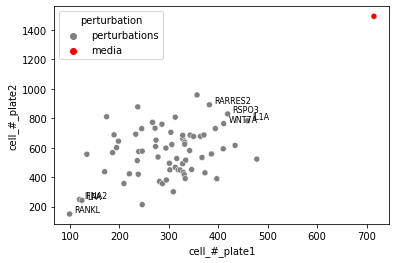

In [107]:
g = sns.scatterplot(data=p1_2_summary, x="cell_#_plate1", y="cell_#_plate2",
                    hue = 'perturbation', palette = ['grey', 'red'])

# Annotate label point 
for pert in list(both_highest)+list(both_lowest):
    x = p1_2_summary.loc[pert,'cell_#_plate1']
    y = p1_2_summary.loc[pert,'cell_#_plate2']
    
    g.text(x + 10, y + 10 , pert, fontsize=8)
    
g.figure.savefig('figures/plate1+2_pool_cell_#.pdf');

## Ingest + finish cNMF

### Functions

In [3]:
# Find knee

def get_knee_list(module_usage, S):
    """
    module_usage: pd.Series
    """
    
    y = module_usage.values
    x=range(1, len(y)+1)
    kn = KneeLocator(x, y, S=S, online=False, curve='convex', direction='decreasing')
    knee_val = kn.knee
        
    return(module_usage.index.values[0:knee_val])

In [4]:
def find_top_GEP(k,density_threshold,path_to_cnmf,cnmf_run,mod_prefix,knee_sens = 3):

    ## Load the Z-scored GEPs which reflect how enriched a gene is in each GEP relative to all of the others
    gene_scores = pd.read_csv(path_to_cnmf+'/'+cnmf_run+'.spectra.k_'+k+'.dt_'+density_threshold+'.consensus.txt',
                              sep='\t', index_col=0).T.add_prefix(mod_prefix)
    
    ## Obtain the top genes (knee method) for each GEP in sorted order, 
    ## and combine them into a single dataframe
    top_genes = []
    for gep in gene_scores.columns:
        gene_list = list(get_knee_list(gene_scores.loc[:,gep].sort_values(ascending=False),S=knee_sens))        
        top_genes.append(gene_list)

    top_genes = pd.DataFrame(top_genes, index=gene_scores.columns).T
    
    ## Load in the cell usage scores for the modules
    usage = pd.read_csv(path_to_cnmf+'/'+cnmf_run+'.usages.k_'+k+".dt_"+density_threshold+'.consensus.txt' ,
                        sep='\t', index_col=0).add_prefix(mod_prefix)
    
    # Normalize
    usage = usage.div(usage.sum(axis=1), axis=0)
    
    return(gene_scores, top_genes, usage)

In [5]:
def filtered_usages(usages, new_module_dict):
    
    filtered_usages = usages.loc[:,usages.columns.isin(list(new_module_dict.keys()))]
    filtered_usages = filtered_usages.rename(columns = new_module_dict)
    filtered_usages.columns = ['Module_%s' % i for i in filtered_usages.columns]
    
    return(filtered_usages)
    

### Plate 1 + Plate 2 - single cNMF run

In [6]:
knee_sens = 2

output_directory = 'cnmf_output/plate1_2_concat/'
run_name = 'cnmf_run'

p1_gene_scores, p1_top_genes, p1_usages = find_top_GEP(k='26',
                                                      density_threshold='0_07',
                                                      path_to_cnmf=output_directory,
                                                      cnmf_run=run_name,
                                                      mod_prefix='Module_',
                                                      knee_sens = knee_sens)

In [35]:
file_name = "k_26_combined_knee_2"

p1_top_genes.to_csv("figures/p1_2_"+file_name+"_top_genes.csv", index=False)
p1_usages.to_csv("figures/p1_2_"+file_name+"_normd_usages.csv")
p1_gene_scores.to_csv("figures/p1_2_"+file_name+"_gene_scores.csv")